In [79]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.patches import Ellipse

import numpy as np
from scipy.special import erfcinv
import scipy.stats as st
from scipy.stats import chi2, multivariate_normal, gamma
from scipy.special import erfcinv, erfinv, erf, erfc
from scipy.linalg import sqrtm, inv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

chi2_val = chi2.ppf(0.6827, df=2)

d = 2
L = 3  # Number of vector
n_samples = int(1e6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path to git repo: /home/matias/Documents/PhD/code


# Three moltivariate distributions

In [80]:
#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

In [81]:
#Define some functions:

def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM


def construct_C(vectors):
    L = len(vectors)

    K_xx = np.sum((vectors[:, 0]) ** 2)
    K_yy = np.sum((vectors[:, 1]) ** 2)
    K_xy = np.sum((vectors[:, 0]) * (vectors[:, 1]))
    K_yx = K_xy
    C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/L
    return C

def analyzed_lambdas(vectors):
    L = len(vectors)
    C = construct_C(vectors)
    lambdas = np.linalg.eigvals(C)
    mean_lambda = np.sum(lambdas)/L
    std_lambda = np.std(lambdas)
    return mean_lambda, std_lambda

def PTE_2_c(PTE):
    aux = gamma(d,1).isf(PTE) #(beta/L)*
    c = 1/(2*aux)
    return c

def PTE_2_l(PTE):
    aux = gamma(d,1).isf(PTE) #(beta/L)*
    l = 2*aux
    return l

def plot_eff_model(PTE, param_with_l=False):
    if PTE == 0:
        print("PTE is zero, cannot plot effective model.")
        return
    else:

        if param_with_l == False:
            c = PTE_2_c(PTE)
            print("Effective model parameter c: ", c)
            mean_A = np.array([-1/2., 0.]) 
            mean_B = np.array([1/2, 0.])
            mean_C = np.array([0, np.sqrt(3)/2.])

            cov_A = c * np.eye(d)
            cov_B = cov_A.copy()
            cov_C = cov_A.copy()

        if param_with_l == True:
            l = PTE_2_l(PTE)
            print("Effective model parameter l: ", l)
            mean_A = l * np.array([-1/2., 0.]) 
            mean_B = l * np.array([1/2, 0.])
            mean_C = l * np.array([0, np.sqrt(3)/2.])

        cov_A = np.eye(d)
        cov_B = cov_A.copy()
        cov_C = cov_A.copy()

        names = ['x', 'y']
        labels = names

        samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
        samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
        samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

        chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
        chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
        chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

        colors = ['red', 'blue', 'green']

        g = plots.get_subplot_plotter()
        g.triangle_plot([chain_A, chain_B, chain_C],\
                        filled=True, contour_args={'alpha':0.5},\
                        contour_colors=colors,
                        legend_labels=['A', 'B', 'C'])

In [82]:
def Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, L, H0=False):
    cov_1 = cov_A + cov_B
    cov_2 = cov_A + cov_C
    cov_3 = cov_B + cov_C

    DA = np.random.multivariate_normal(mean_A, cov_A, size=n_samples)
    DB = np.random.multivariate_normal(mean_B, cov_B, size=n_samples)
    DC = np.random.multivariate_normal(mean_C, cov_C, size=n_samples)
    

    # Sampling
    sample_1 = np.dot(sqrtm(np.linalg.inv(cov_1)), np.array(DA-DB).T)  # Shape: (d, n_samples)
    sample_2 = np.dot(sqrtm(np.linalg.inv(cov_2)), np.array(DA-DC).T)  # Shape: (d, n_samples)
    sample_3 = np.dot(sqrtm(np.linalg.inv(cov_3)), np.array(DB-DC).T)  # Shape: (d, n_samples)
    
    if H0==True:
        sample_1_H0 = sample_1 - np.mean(sample_1, axis=1, keepdims=True)
        sample_2_H0 = sample_2 - np.mean(sample_2, axis=1, keepdims=True)
        sample_3_H0 = sample_3 - np.mean(sample_3, axis=1, keepdims=True)
        
        Q = np.zeros(n_samples)
        for i in range(n_samples):
            Q[i] = np.linalg.norm(sample_1_H0[:,i])**2 + np.linalg.norm(sample_2_H0[:,i])**2 + np.linalg.norm(sample_3_H0[:,i])**2       
    else:
        Q = np.zeros(n_samples)
        for i in range(n_samples):
            Q[i] = np.linalg.norm(sample_1[:,i])**2 + np.linalg.norm(sample_2[:,i])**2 + np.linalg.norm(sample_3[:,i])**2

    return Q / L

In [ ]:
def plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title, name_plot, png=True, eff_dist = False,
              analytic_tension = False):

    names = ['x', 'y']
    labels = ['x', 'y']

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
    r_4 = - r_1
    r_5 = - r_2
    r_6 = - r_3

    # Example usage:
    C_tot = construct_C(np.array([r_1, r_2, r_3, r_4, r_5, r_6]))

    beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2)/3
    if analytic_tension == False:
        Q_H0 =Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, 3, H0=True)
        PTE = Q_H0[Q_H0 > beta_L].size/Q_H0.size
        
    elif analytic_tension == True:
        PTE = gamma(d,1).sf(beta_L)

    n_sigma = np.sqrt(2)*erfcinv(PTE)


    lim_x = np.array([-10, 10])
    lim_y = np.array([-10, 10])

    samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
    samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
    samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

    chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
    chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
    chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

    colors = ['red', 'blue', 'green']

    g = plots.get_subplot_plotter()
    g.triangle_plot([chain_A, chain_B, chain_C],\
                    filled=True, contour_args={'alpha':0.5},\
                    contour_colors=colors,
                    legend_labels=['A', 'B', 'C'])
    os.chdir(os.path.join(path_git, 'notebooks', 'tests', 'figures'))
    if png==True:
        g.export('dist_{}.png'.format(name_plot))
    else:
        g.export('dist_{}.pdf'.format(name_plot))


    #fig, ax = plt.subplots(1,1, figsize=(14,10))
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    fig.suptitle(title, fontsize=16)


    ax.set_xlabel(r'$\Delta x$',size=14)
    ax.set_ylabel(r'$\Delta y$',size=14)
    ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
    ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

    ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
    ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
    ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
    ax.quiver(0, 0, r_4[0], r_4[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
    ax.quiver(0, 0, r_5[0], r_5[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
    ax.quiver(0, 0, r_6[0], r_6[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

    ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
    ax.scatter([0], [0], color='black')#, label='CM')

    ax.quiver(0, 0, np.linalg.eig(C_tot)[1][0, 0], np.linalg.eig(C_tot)[1][1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(np.linalg.eig(C_tot)[0][0]))
    ax.quiver(0, 0, np.linalg.eig(C_tot)[1][0, 1], np.linalg.eig(C_tot)[1][1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(np.linalg.eig(C_tot)[0][1]))

    ax.text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
    ax.text(r_2[0]-0.2, r_2[1]-0.3, 'AC', size=10)
    ax.text(r_3[0]-0.0, r_3[1]-0.3, 'BC', size=10)
    ax.text(r_4[0]-0.5, r_4[1]+0.2, 'BA', size=10)
    ax.text(r_5[0]-0.2, r_5[1]-0.3, 'CA', size=10)
    ax.text(r_6[0]-0.0, r_6[1]-0.3, 'CB', size=10)

    ax.set_xlim(*lim_x)
    ax.set_ylim(*lim_y)

    ax.legend()
    ax.grid()

    # Para mostrar ambas leyendas en la parte inferior, puedes usar handles y labels manualmente:
    handles1, labels1 = ax.get_legend_handles_labels()
    legend1 = ax.legend(handles=handles1, labels=labels1, loc='lower left', fontsize=12)
    ax.add_artist(legend1)

    legend2 = ax.legend(
        [f'Det = {np.prod(np.linalg.eigvals(C_tot)):.3g}', 
        f'Tr = {np.sum(np.linalg.eigvals(C_tot)):.3g}',
        f'Ecc = {np.sqrt(1-np.min(np.linalg.eigvals(C_tot)) / np.max(np.linalg.eigvals(C_tot))):.3g}',
        f'N_\sigma = {n_sigma:.3g}'],
        loc='lower right', fontsize=9, title='Properties'
    )


    os.chdir(os.path.join(path_git, 'notebooks', 'tests', 'figures'))
    if png==True:
        fig.savefig('geom_{}_beta.png'.format(name_plot), dpi=300, bbox_inches='tight')
    else:
        fig.savefig('geom_{}_beta.pdf'.format(name_plot), dpi=300, bbox_inches='tight')
    plt.show()

    if eff_dist == True:
        print(PTE)
        plot_eff_model(PTE)

# Case 1

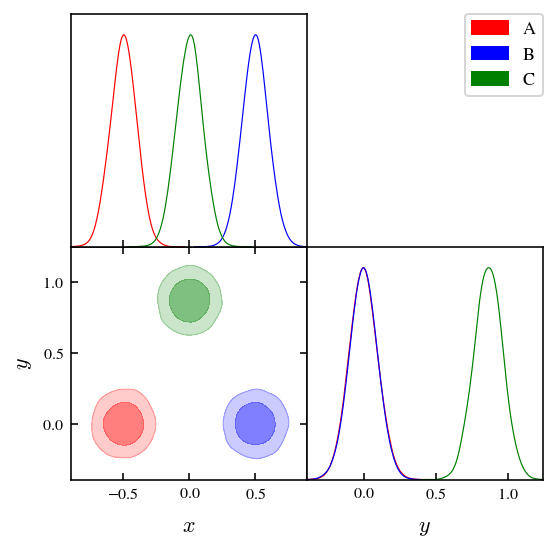

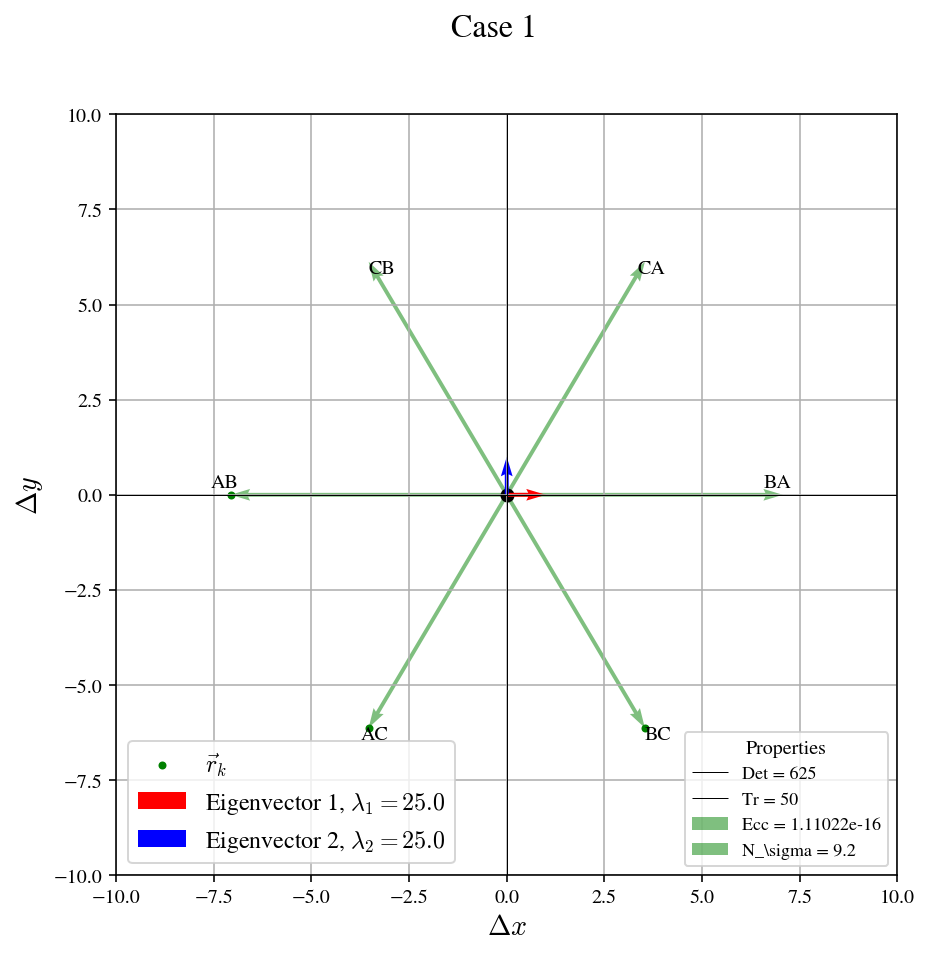

All eigenvalues are equal, is not necessary to analyze further: max:25 and min:25


In [ ]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 1', name_plot='1', 
          analytic_tension=True)

vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
C = construct_C(vectors)
eigenval_min = np.min(np.linalg.eigvals(C))
eigenval_max = np.max(np.linalg.eigvals(C))

if np.linalg.det(C) == 0:
    print('Determinant is zero.. for a deeper analysis reduce the dimension')

elif np.abs(eigenval_min - eigenval_max) < 1e-3:
    print(f'All eigenvalues are equal, is not necessary to analyze further: max:{eigenval_min :.3g} and min:{eigenval_max :.3g}')
else:
    mean_lambda, std_lambda = analyzed_lambdas(vectors)
    print(f'Mean eigenvalue: {mean_lambda :.3g}, Standard deviation: {std_lambda :.3g}')


# Case 2

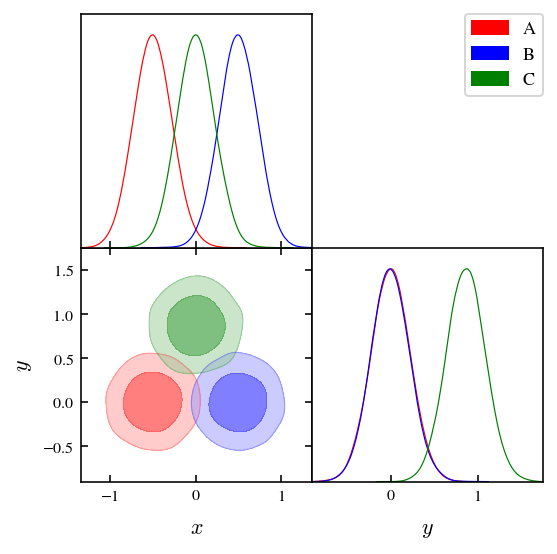

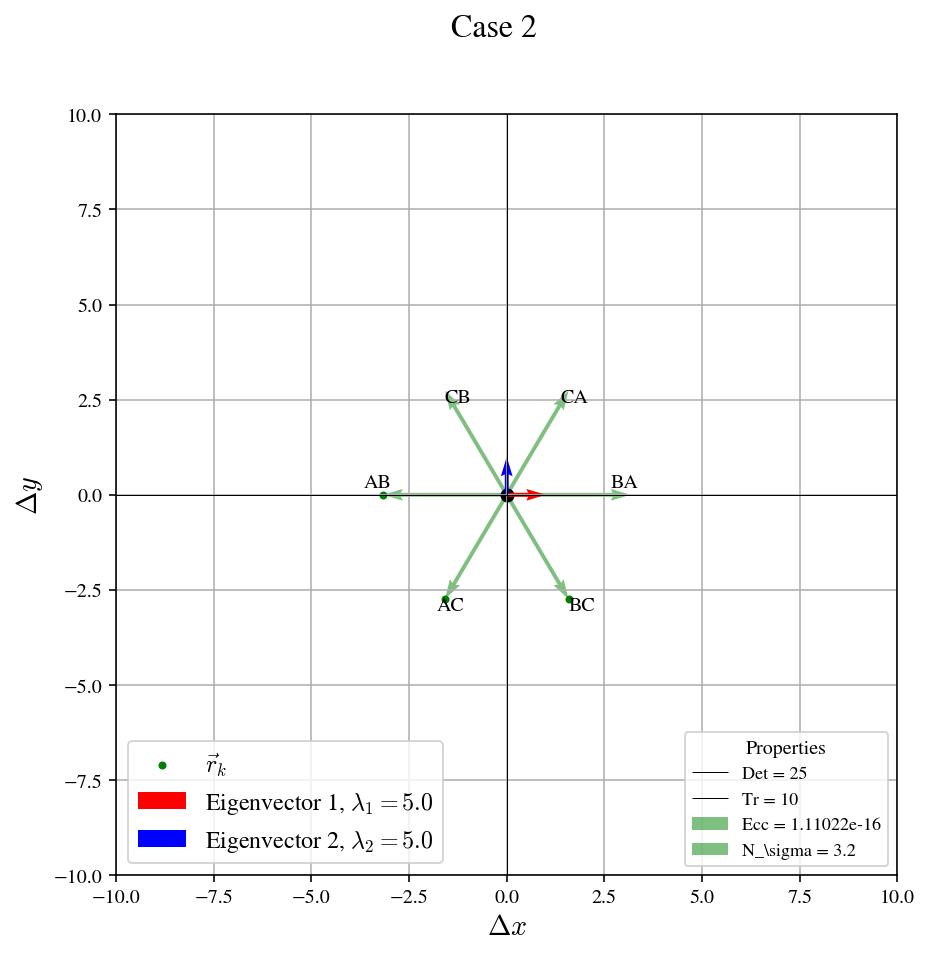

All eigenvalues are equal:  5 and  5


In [ ]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = 5*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()


r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 2', name_plot='2', analytic_tension=True)

vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
C = construct_C(vectors)
eigenval_min = np.min(np.linalg.eigvals(C))
eigenval_max = np.max(np.linalg.eigvals(C))

if np.linalg.det(C) == 0:
    print('Determinant is zero.. for a deeper analysis reduce the dimension')

elif np.abs(eigenval_min - eigenval_max) < 1e-3:
    print(f'All eigenvalues are equal: {eigenval_min :.3g} and {eigenval_max :.3g}')
else:
    mean_lambda, std_lambda = analyzed_lambdas(vectors)
    print(f'Mean eigenvalue: {mean_lambda :.3g}, Standard deviation: {std_lambda :.3g}')

# Case Susana 1

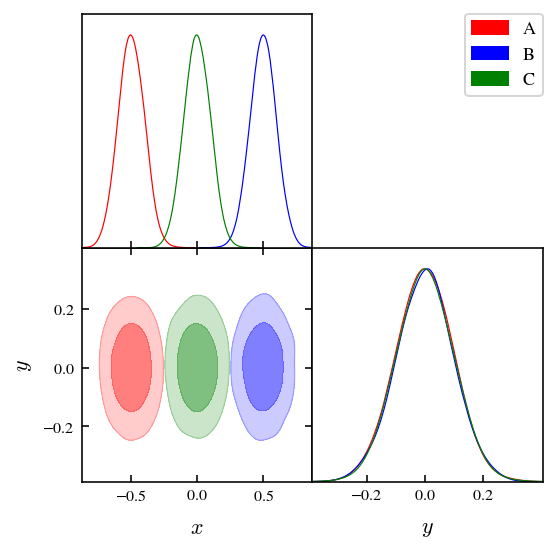

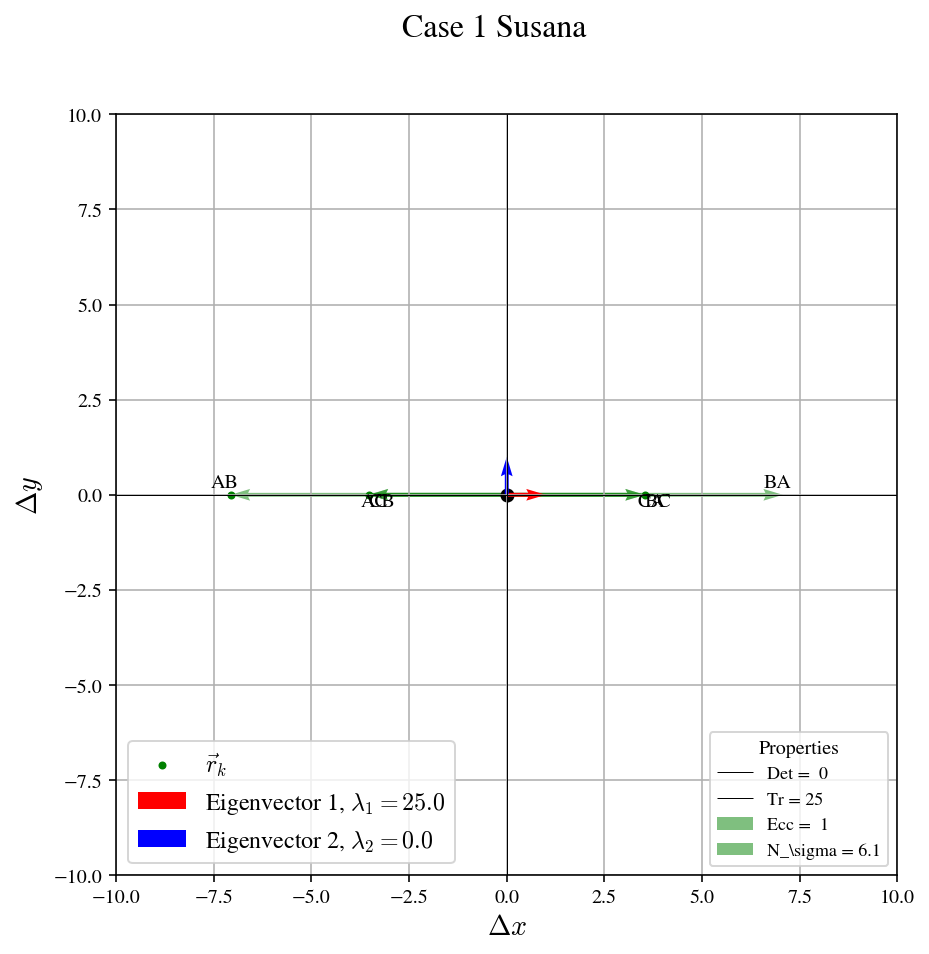

9.437836360697703e-10
Effective model parameter c:  0.01999999997417469
Determinant is zero.. for a deeper analysis reduce the dimension
$N_\sigma_beta$ = inf
PTE is zero, cannot plot effective model.


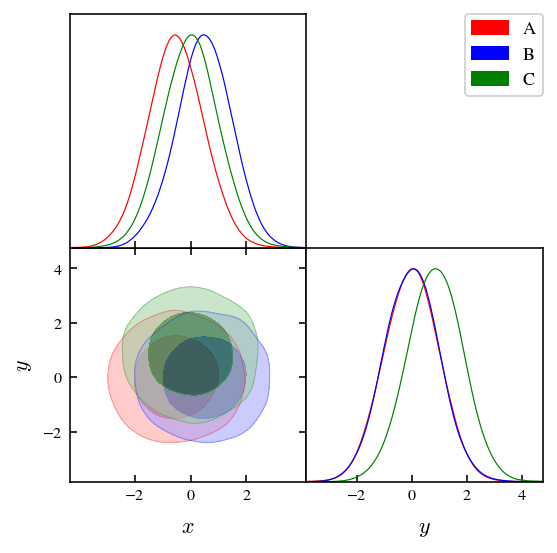

In [ ]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, 0.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()


r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 1 Susana', name_plot='susana_1',
          analytic_tension=True, eff_dist=True)

vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
C = construct_C(vectors)
eigenval_min = np.min(np.linalg.eigvals(C))
eigenval_max = np.max(np.linalg.eigvals(C))

if np.linalg.det(C) == 0:
    print('Determinant is zero.. for a deeper analysis reduce the dimension')

elif np.abs(eigenval_min - eigenval_max) < 1e-3:
    print(f'All eigenvalues are equal: {eigenval_min :.3g} and {eigenval_max :.3g}')
else:
    mean_lambda, std_lambda = analyzed_lambdas(vectors)
    print(f'Mean eigenvalue: {mean_lambda :.3g}, Standard deviation: {std_lambda :.3g}')
beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2)/3
Q_H0 =Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, 3, H0=True)
PTE = Q_H0[Q_H0 > beta_L].size/Q_H0.size
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'$N_\sigma_beta$ = {n_sigma:.3g}')

plot_eff_model(PTE)

# Case Susana 2

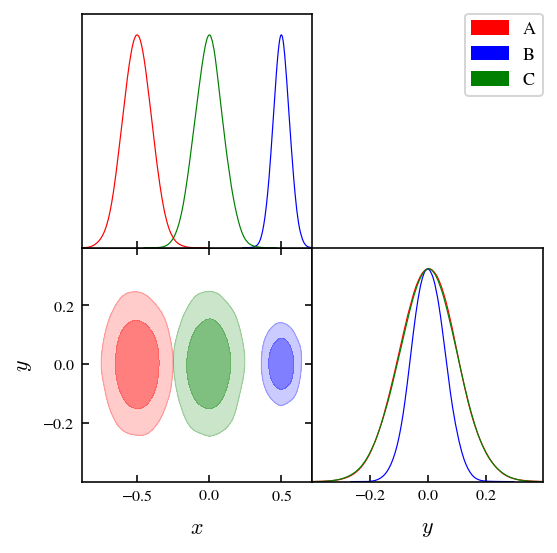

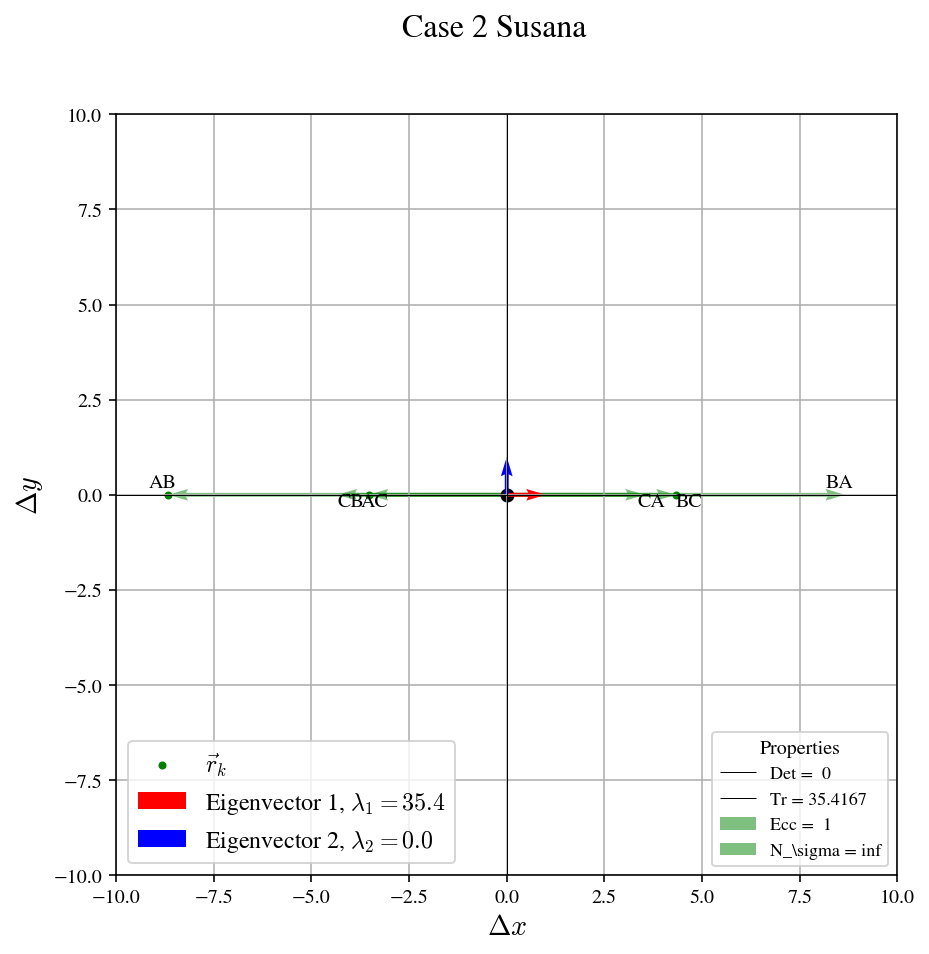

Determinant is zero.. for a deeper analysis reduce the dimension


In [ ]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, 0.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()/3
cov_C = cov_A.copy()

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 2 Susana', name_plot='susana_2')

vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
C = construct_C(vectors)
eigenval_min = np.min(np.linalg.eigvals(C))
eigenval_max = np.max(np.linalg.eigvals(C))

if np.linalg.det(C) == 0:
    print('Determinant is zero.. for a deeper analysis reduce the dimension')

elif np.abs(eigenval_min - eigenval_max) < 1e-3:
    print(f'All eigenvalues are equal: {eigenval_min :.3g} and {eigenval_max :.3g}')
else:
    mean_lambda, std_lambda = analyzed_lambdas(vectors)
    print(f'Mean eigenvalue: {mean_lambda :.3g}, Standard deviation: {std_lambda :.3g}')


# Case Susana 3

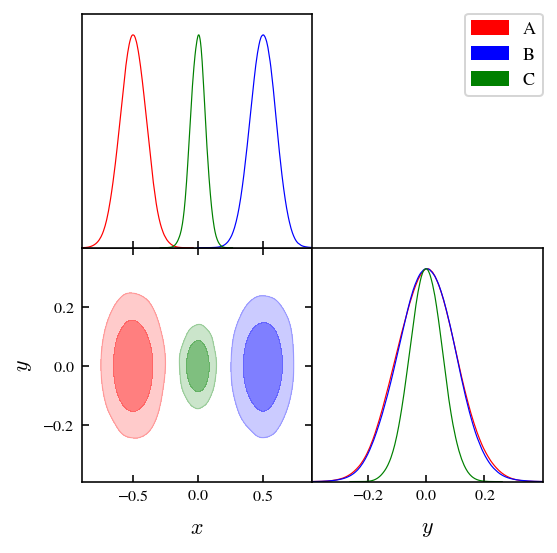

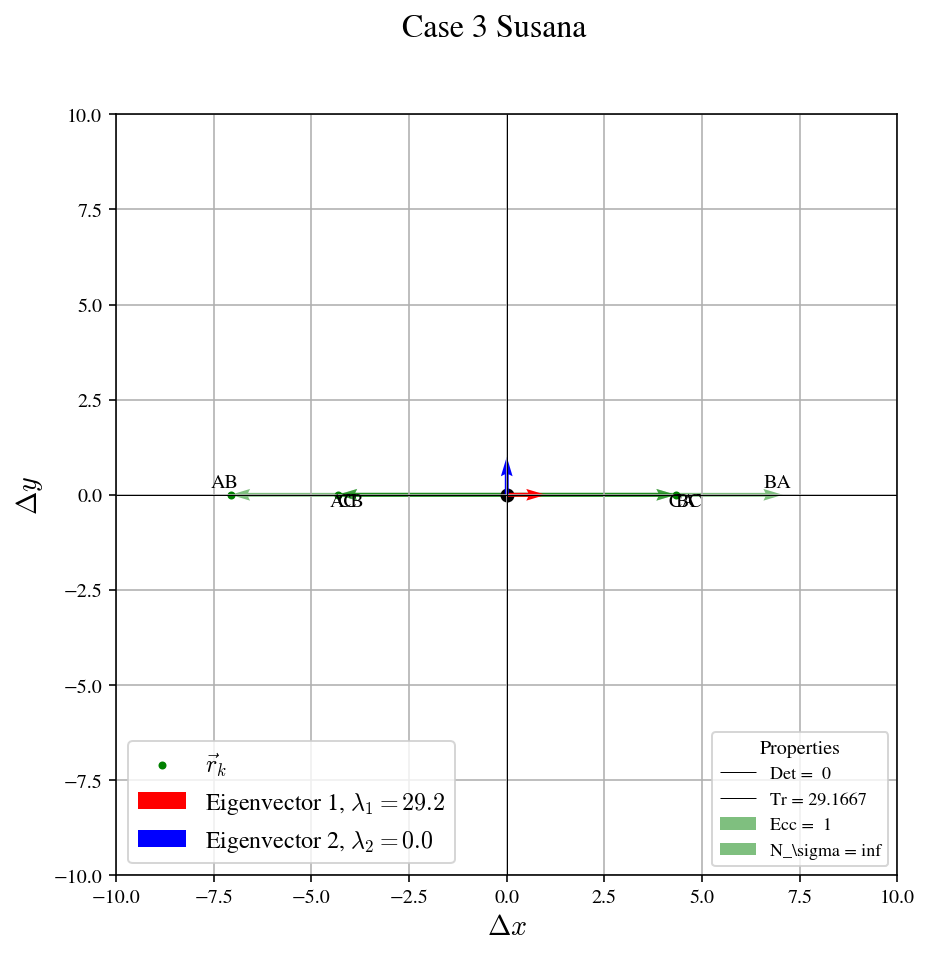

Determinant is zero.. for a deeper analysis reduce the dimension


In [ ]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, 0.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()/3

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 3 Susana', name_plot='susana_3')

vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
C = construct_C(vectors)
eigenval_min = np.min(np.linalg.eigvals(C))
eigenval_max = np.max(np.linalg.eigvals(C))

if np.linalg.det(C) == 0:
    print('Determinant is zero.. for a deeper analysis reduce the dimension')

elif np.abs(eigenval_min - eigenval_max) < 1e-3:
    print(f'All eigenvalues are equal: {eigenval_min :.3g} and {eigenval_max :.3g}')
else:
    mean_lambda, std_lambda = analyzed_lambdas(vectors)
    print(f'Mean eigenvalue: {mean_lambda :.3g}, Standard deviation: {std_lambda :.3g}')

# Case 3

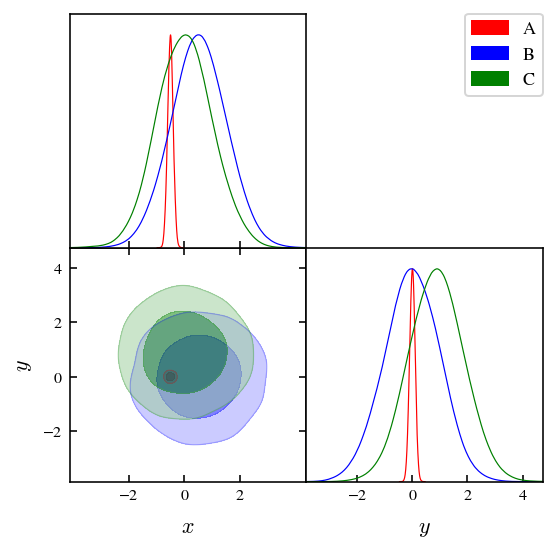

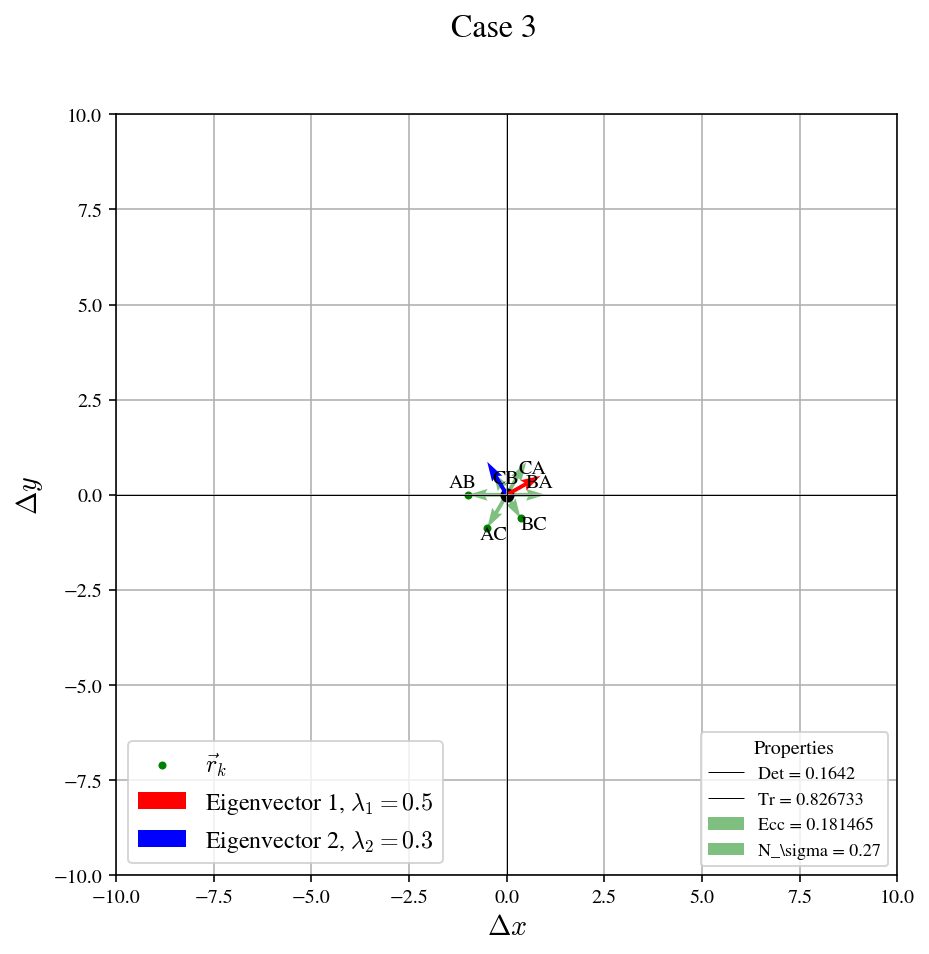

0.787187
Effective model parameter c:  0.26885912031984505
Mean eigenvalue: 0.137789, Standard deviation: 0.0816832


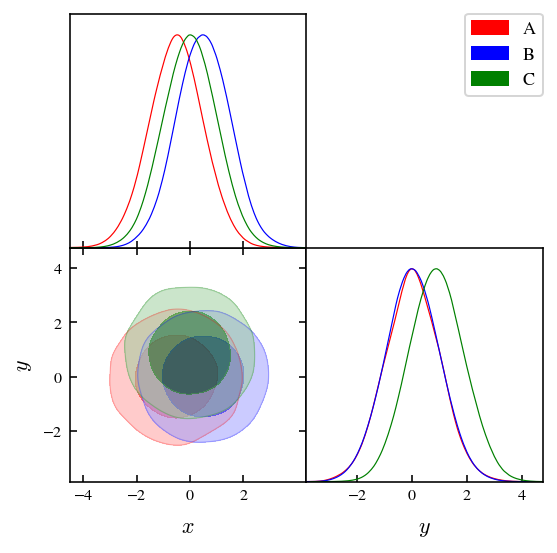

In [ ]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = 100*cov_A.copy()
cov_C = 100*cov_A.copy()

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 3', name_plot='3', eff_dist=True)

vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
C = construct_C(vectors)
eigenval_min = np.min(np.linalg.eigvals(C))
eigenval_max = np.max(np.linalg.eigvals(C))

if np.linalg.det(C) == 0:
    print('Determinant is zero.. for a deeper analysis reduce the dimension')

elif np.abs(eigenval_min - eigenval_max) < 1e-3:
    print(f'All eigenvalues are equal: {eigenval_min :.3g} and {eigenval_max :.3g}')
else:
    mean_lambda, std_lambda = analyzed_lambdas(vectors)
    print(f'Mean eigenvalue: {mean_lambda :.3g}, Standard deviation: {std_lambda :.3g}')

    k = mean_lambda**2 / std_lambda**2
    theta = std_lambda**2 / mean_lambda
    dist_1 = st.gamma(a=k, scale=theta, loc=0).rvs(1000)

    sigma_ln = np.sqrt(np.log(1 + std_lambda**2 / mean_lambda**2))
    mu_ln = np.log(mean_lambda) - 0.5*sigma_ln**2
    dist_2 = st.lognorm(s=sigma_ln, scale=np.exp(mu_ln)).rvs(1000)

    dist_3 = st.norm(loc=mean_lambda, scale=std_lambda).rvs(1000)
    '''
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.grid()
    ax.hist(dist_1, bins=int(np.sqrt(len(dist_1))), density=True, alpha=0.5)
    ax.hist(dist_2, bins=int(np.sqrt(len(dist_2))), density=True, alpha=0.5)
    ax.hist(dist_3[dist_3 > 0], bins=int(np.sqrt(len(dist_3[dist_3 > 0]))), density=True, alpha=0.5)
    ax.set_title("Distribución de la varianza")
    plt.show()
    '''

# Case 4

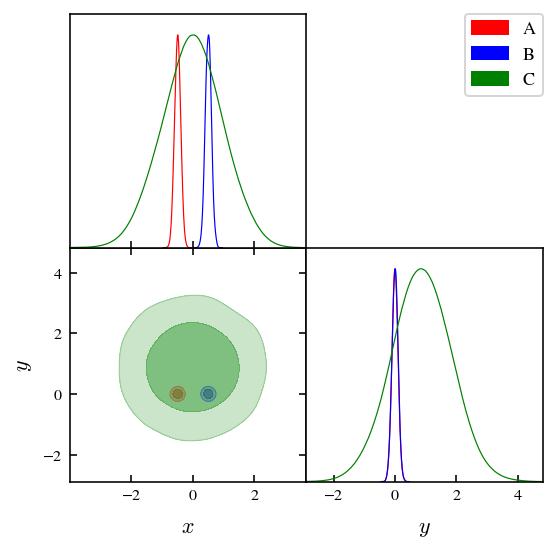

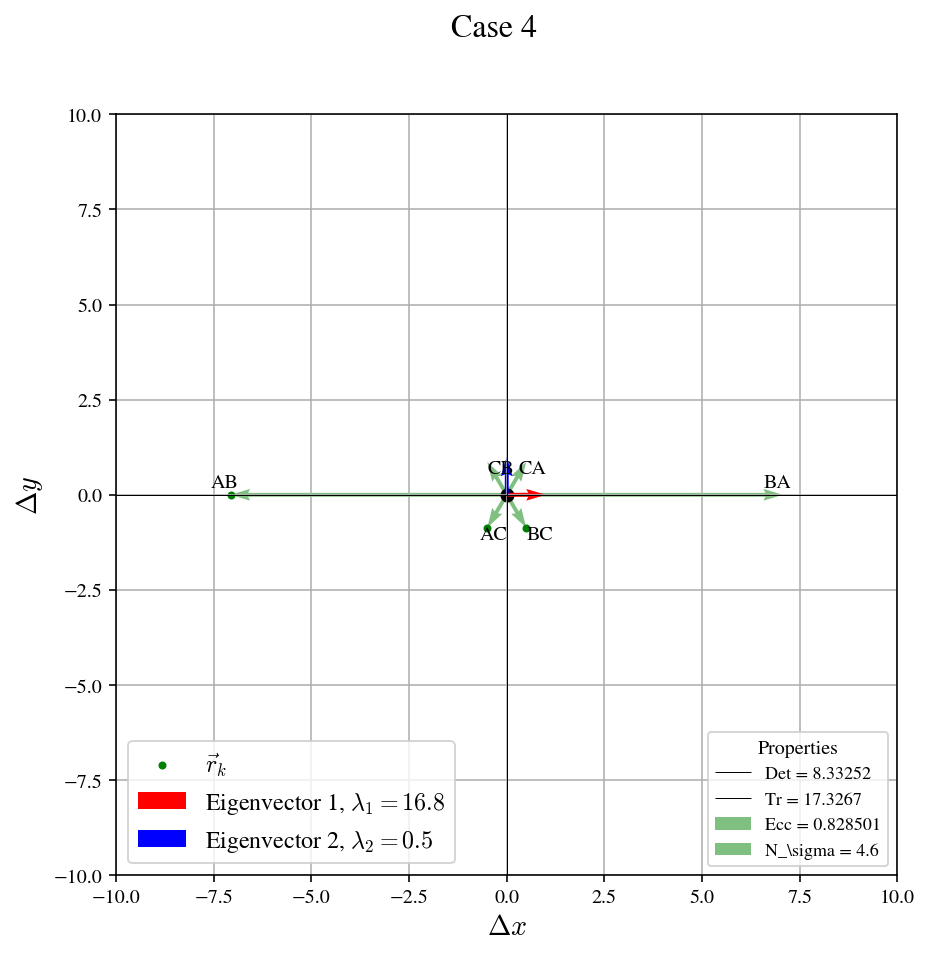

5e-06
Effective model parameter c:  0.0312945209314627
Mean eigenvalue: 2.88779, Standard deviation: 8.16832


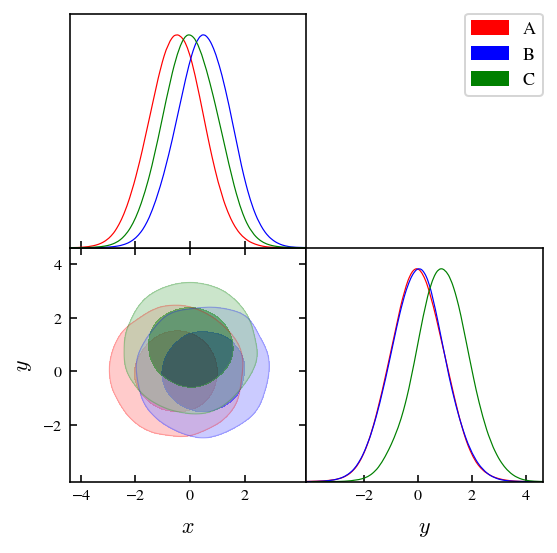

In [ ]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = 100*cov_A.copy()

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 4', name_plot='4', eff_dist=True)

vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
C = construct_C(vectors)
eigenval_min = np.min(np.linalg.eigvals(C))
eigenval_max = np.max(np.linalg.eigvals(C))

if np.linalg.det(C) == 0:
    print('Determinant is zero.. for a deeper analysis reduce the dimension')

elif np.abs(eigenval_min - eigenval_max) < 1e-3:
    print(f'All eigenvalues are equal: {eigenval_min :.3g} and {eigenval_max :.3g}')
else:
    mean_lambda, std_lambda = analyzed_lambdas(vectors)
    print(f'Mean eigenvalue: {mean_lambda :.3g}, Standard deviation: {std_lambda :.3g}')


    k = mean_lambda**2 / std_lambda**2
    theta = std_lambda**2 / mean_lambda
    dist_1 = st.gamma(a=k, scale=theta, loc=0).rvs(1000)

    sigma_ln = np.sqrt(np.log(1 + std_lambda**2 / mean_lambda**2))
    mu_ln = np.log(mean_lambda) - 0.5*sigma_ln**2
    dist_2 = st.lognorm(s=sigma_ln, scale=np.exp(mu_ln)).rvs(1000)

    dist_3 = st.norm(loc=mean_lambda, scale=std_lambda).rvs(1000)
    '''
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.grid()
    ax.hist(dist_1, bins=int(np.sqrt(len(dist_1))), density=True, alpha=0.5)
    ax.hist(dist_2, bins=int(np.sqrt(len(dist_2))), density=True, alpha=0.5)
    ax.hist(dist_3[dist_3 > 0], bins=int(np.sqrt(len(dist_3[dist_3 > 0]))), density=True, alpha=0.5)
    ax.set_title("Distribución de la varianza")
    plt.show()
    '''

In [91]:
dist = gamma(d,1)
print(dist.sf(3))
print(dist.isf(0.40600584970983794))

0.40600584970983794
3.0
